In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

ValueError: mount failed

In [ ]:
%cd /content/drive/MyDrive/CursoPINN-CEIA-UBA/Modulo6

# Definición de las redes "branch" y "trunk", y de la DeepONet

In [ ]:
# Define the Branch Network
class BranchNet(nn.Module):
    def __init__(self, branchNet_params):
        super(BranchNet, self).__init__()
        self.Device = branchNet_params["Device"]
        self.InputDimensions = branchNet_params["InputDimensions"]
        self.OutputDimensions = branchNet_params["OutputDimensions"]
        self.NumberOfNeurons = branchNet_params["NumberOfNeurons"]
        self.NumberOfHiddenLayers = branchNet_params["NumberOfHiddenLayers"]
        self.ActivationFunction = branchNet_params["ActivationFunction"]
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)

    def forward(self, x):
        output = self.ActivationFunction(self.InputLayer(x))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output

# Define the Trunk Network
class TrunkNet(nn.Module):
    def __init__(self, trunkNet_params):
        super(TrunkNet, self).__init__()
        self.Device = trunkNet_params["Device"]
        self.InputDimensions = trunkNet_params["InputDimensions"]
        self.OutputDimensions = trunkNet_params["OutputDimensions"]
        self.NumberOfNeurons = trunkNet_params["NumberOfNeurons"]
        self.NumberOfHiddenLayers = trunkNet_params["NumberOfHiddenLayers"]
        self.ActivationFunction = trunkNet_params["ActivationFunction"]
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)

    def forward(self, x):
        output = self.ActivationFunction(self.InputLayer(x))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output


# Define the DeepONet
class DeepONet(nn.Module):
    def __init__(self, branch_net, trunk_net):
        super(DeepONet, self).__init__()
        self.branch_net = branch_net
        self.trunk_net = trunk_net

    def forward(self, branch_input, trunk_input):
        # Get branch and trunk outputs
        branch_output = self.branch_net(branch_input)  # Shape: [batch_size, branch_output_dim]
        trunk_output = self.trunk_net(trunk_input)    # Shape: [batch_size, trunk_output_dim]

        # Combine the outputs (dot product across the last dimension)
        combined_output = torch.sum(branch_output*trunk_output, dim=-1)
        return combined_output


# Data

In [ ]:
# Download training data
d = np.load("antiderivative_unaligned_train.npz", allow_pickle=True)
v_train = torch.from_numpy(d["X_train0"]).to(torch.float32).to(device)
x_train = torch.from_numpy(d["X_train1"]).to(torch.float32).to(device)
u_train = torch.from_numpy(d["y_train"]).to(torch.float32).to(device)

# Download testing data
d = np.load("antiderivative_unaligned_test.npz", allow_pickle=True)
v_test = torch.from_numpy(d["X_test0"]).to(torch.float32).to(device)
x_test = torch.from_numpy(d["X_test1"]).to(torch.float32).to(device)
u_test = torch.from_numpy(d["y_test"]).to(torch.float32).to(device)

idx_test = np.random.choice(len(x_test), 100, replace=False)

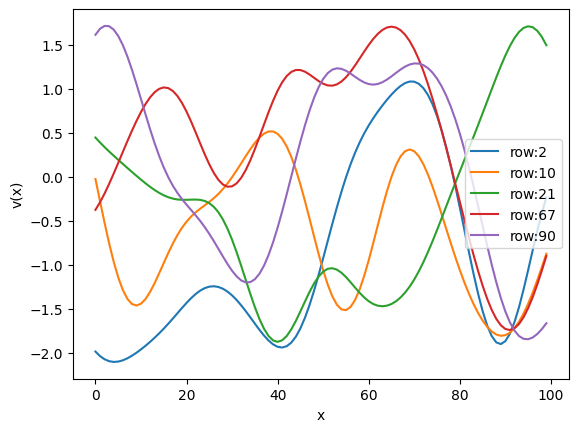

In [ ]:
rows = [2, 10, 21, 67, 90]
for row in rows:
    plt.plot(v_train[row, :].data.cpu().detach().numpy(), label=f'row:{row}')

plt.xlabel('x')
plt.ylabel('v(x)')
plt.legend()
plt.show()

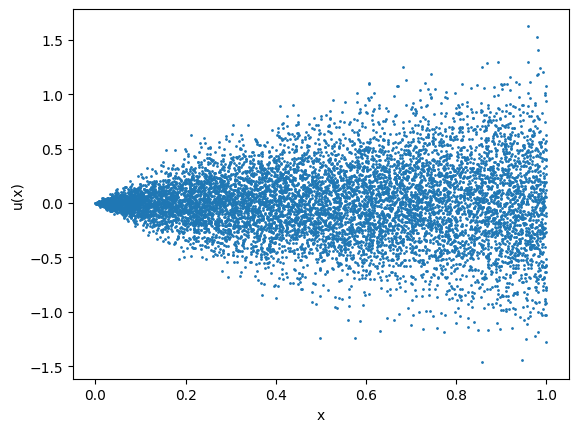

In [ ]:
plt.scatter(x_train.data.cpu().detach().numpy(), u_train.data.cpu().detach().numpy(), s=1)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.show()

# Main execution

In [ ]:
# Initialization parameters
branchNet_params = {
    "Device": device,
    "InputDimensions": 100,
    "OutputDimensions": 100,
    "NumberOfNeurons": 40,
    "NumberOfHiddenLayers": 2,
    "ActivationFunction": nn.Tanh()
}

trunkNet_params = {
    "Device": device,
    "InputDimensions": 1,
    "OutputDimensions": 100,
    "NumberOfNeurons": 40,
    "NumberOfHiddenLayers": 2,
    "ActivationFunction": nn.Tanh()
}

In [ ]:
def init_xavier(model):
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            # gain = nn.init.calculate_gain('tanh')
            gain = 1
            torch.nn.init.xavier_uniform_(m.weight, gain=gain)
            torch.nn.init.uniform_(m.bias, 0, 1)

    model.apply(init_weights)

In [ ]:
# Build model
branch_net = BranchNet(branchNet_params).to(device)
init_xavier(branch_net)
trunk_net = TrunkNet(trunkNet_params).to(device)
init_xavier(trunk_net)
model = DeepONet(branch_net, trunk_net).to(device)

In [ ]:
# Training Setup
epochs = 1000
lr = 1e-4
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_err_list = []
test_err_list = []
train_loss_list = []
test_loss_list = []
for epoch in range(epochs):

    # Train stage
    model.train()
    optimizer.zero_grad()
    u_train_pred = model.forward(v_train, x_train)
    train_loss = criterion(u_train_pred, u_train)
    train_loss.backward()
    optimizer.step()
    train_err = np.mean(np.linalg.norm(u_train.data.cpu().detach().numpy() - u_train_pred.data.cpu().detach().numpy(), 2, axis=1)/\
                np.linalg.norm(u_train.data.cpu().detach().numpy(), 2, axis=1))
    train_loss_list.append(train_loss.item())
    train_err_list.append(train_err.item())

    # Test stage
    model.eval()
    with torch.no_grad():
        u_test_pred = model.forward(v_test[idx_test, :], x_test[idx_test, :])
        test_loss = criterion(u_test_pred, u_test[idx_test, :])
        test_err = np.mean(np.linalg.norm(u_test.data.cpu().detach().numpy() - u_test_pred.data.cpu().detach().numpy(), 2, axis=1)/\
                    np.linalg.norm(u_test.data.cpu().detach().numpy(), 2, axis=1))
        test_loss_list.append(test_loss.item())
        test_err_list.append(test_err.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss:.6f}")
        print(f"Epoch {epoch+1}, Test Loss: {test_loss:.6f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10000, 1])) that is different to the input size (torch.Size([10000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Training Loss: 0.516799
Epoch 1, Test Loss: 0.537262
Epoch 101, Training Loss: 0.169540
Epoch 101, Test Loss: 0.183192
Epoch 201, Training Loss: 0.130985
Epoch 201, Test Loss: 0.140421
Epoch 301, Training Loss: 0.119672
Epoch 301, Test Loss: 0.128470
Epoch 401, Training Loss: 0.114864
Epoch 401, Test Loss: 0.123341
Epoch 501, Training Loss: 0.112425
Epoch 501, Test Loss: 0.120706
Epoch 601, Training Loss: 0.111038
Epoch 601, Test Loss: 0.119195
Epoch 701, Training Loss: 0.110202
Epoch 701, Test Loss: 0.118083


KeyboardInterrupt: 

# Plotting

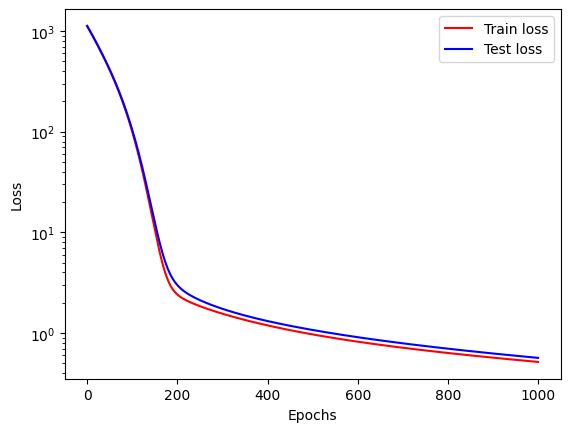

In [ ]:
# Losses
plt.semilogy(np.arange(epochs), train_loss_list, color='r', label='Train loss')
plt.semilogy(np.arange(epochs), test_loss_list, color='b', label='Test loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

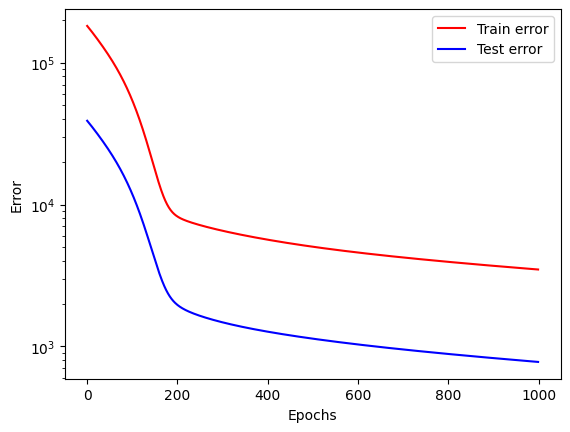

In [ ]:
# L2 errors
plt.semilogy(np.arange(epochs), train_err_list, color='r', label='Train error')
plt.semilogy(np.arange(epochs), test_err_list, color='b', label='Test error')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

# Predictions

In [ ]:
x_trial = torch.linspace(0, 1, 100).to(device)
v_trial = -torch.cos(2*torch.pi*x_trial).to(device)
u_pred = model.forward(v_trial.repeat(100, 1), x_trial.view(-1, 1))

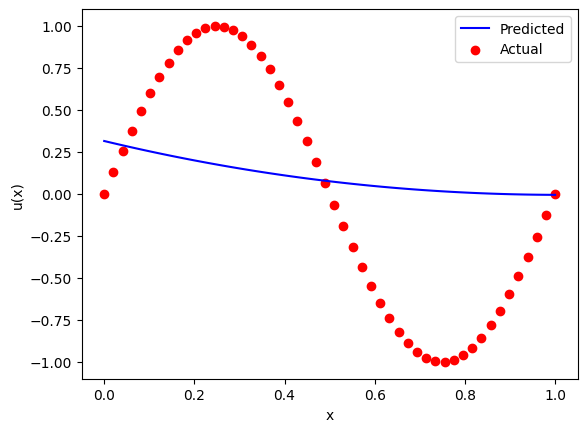

In [ ]:
plt.plot(np.linspace(0, 1, 100), u_pred.data.cpu().detach().numpy(), color='b', label='Predicted')
plt.scatter(np.linspace(0, 1, 50), np.sin(2*np.pi*np.linspace(0, 1, 50)), color='r', label='Actual')
plt.legend()
plt.xlabel('x')
plt.ylabel('u(x)')
plt.show()